# Crude Oil Forecasting Model 

This project builds a machine learning pipeline to forecast WTI crude oil prices using historical and macroeconomic data. The objective is to generate a realistic and smooth 1-month price forecast using models like XGBoost and Random Forest, and visualise them effectively for stakeholders.


## Crude Oil Forecasting Model – Executive Summary

This project aims to forecast **WTI Crude Oil Prices** using supervised machine learning models based on historical and macroeconomic indicators. The target variable is the actual monthly WTI crude oil price, and the dataset includes relevant engineered features from global financial and energy data sources.

The following steps were performed:
- Data preprocessing including scaling and feature selection.
- Model training using **Random Forest Regressor** and **XGBoost Regressor**.
- Performance evaluation using **MAE, RMSE, and R² score**.
- **Hyperparameter tuning** with RandomizedSearchCV to enhance model performance.
- Feature importance analysis to interpret model decisions.
- A **1-month forecast horizon** was selected, targeting WTI prices for January.
- Visualisation of actual vs predicted prices to assess model accuracy.

### Key Results:
- **Random Forest (Tuned):** RMSE = 0.1607, R² = 0.993
- **XGBoost (Tuned):** RMSE = 0.1916, R² = 0.990
- Both models demonstrate strong predictive performance, with XGBoost offering slightly better generalisation.

This notebook reflects strong foundations in machine learning workflows, model interpretability, and forecasting methodologies, suitable for applications in energy analytics and financial prediction domains.


In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


## 1. Data Loading and Initial Exploration

We begin by importing the required libraries and loading the dataset. Basic exploration is done to understand structure, missing values, and trends.


In [1]:
import yfinance as yf
import pandas as pd

# Fetching Brent Crude Oil prices from Yahoo Finance (ticker: "BZ=F")
# We're collecting daily data starting from Jan 2018 to Dec 2024
brent_data = yf.download("BZ=F", start="2018-01-01", end="2024-12-31", interval="1d")

# Resetting the index so that 'Date' becomes a regular column instead of the index
brent_data.reset_index(inplace=True)

# Keeping only the date and closing price, and renaming 'Close' for better clarity
brent_clean = brent_data[['Date', 'Close']].rename(columns={'Close': 'brent_crude_price'})

# Saving the cleaned dataset to a CSV file for further use in modeling or visualization
brent_clean.to_csv("brent_crude_clean.csv", index=False)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
import yfinance as yf
import pandas as pd

# Downloading WTI Crude Oil prices using Yahoo Finance (ticker: "CL=F")
# We're pulling daily data from Jan 2018 to Dec 2024
wti_data = yf.download("CL=F", start="2018-01-01", end="2024-12-31", interval="1d")

# Resetting the index so that 'Date' becomes a separate column instead of being the index
wti_data.reset_index(inplace=True)

# Selecting just the date and closing price columns, and renaming for better understanding
wti_clean = wti_data[['Date', 'Close']].rename(columns={'Close': 'wti_crude_price'})

# Saving the cleaned WTI data to a CSV file for use in our forecasting model
wti_clean.to_csv("wti_crude_clean.csv", index=False)


[*********************100%***********************]  1 of 1 completed


In [5]:
import yfinance as yf
import pandas as pd

# Defining the ticker for WTI Crude Oil Futures on Yahoo Finance
ticker = "CL=F"
start_date = "2018-01-01"
end_date = "2024-12-31"

# Downloading historical data from Yahoo Finance for the specified date range
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Proceeding only if data is successfully fetched
if not data.empty:
    # Resetting the index and selecting the date and closing price
    # Renaming 'Close' to make the column name more descriptive
    df_wti_eia = data.reset_index()[["Date", "Close"]].rename(columns={"Close": "wti_crude_eia_price"})
    
    # Saving the cleaned data to a CSV file for later use
    df_wti_eia.to_csv("wti_crude_eia_clean.csv", index=False)

else:
    # In case data wasn't fetched (e.g., due to connectivity issues)
    print("No data returned. Try again or check internet/firewall.")


In [7]:
import yfinance as yf
import pandas as pd

# Downloading the US Dollar Index (DXY) data from Yahoo Finance
# The ticker "DX-Y.NYB" represents the DXY index on the NYBOT exchange
dxy_data = yf.download("DX-Y.NYB", start="2018-01-01", end="2024-12-31", interval="1d")

# Resetting the index so 'Date' becomes a separate column instead of being the index
dxy_data.reset_index(inplace=True)

# Keeping only the Date and Close columns, and renaming 'Close' for better clarity
dxy_clean = dxy_data[['Date', 'Close']].rename(columns={'Close': 'us_dxy_index'})

# Saving the cleaned DXY index data to a CSV file for later use in analysis or modeling
dxy_clean.to_csv("us_dxy_index_clean.csv", index=False)


[*********************100%***********************]  1 of 1 completed


In [9]:
import requests
import pandas as pd

# Importing necessary libraries: 'requests' to call APIs and 'pandas' to work with the data easily

# Setting up the FRED API key that we'll use to authenticate our request
api_key = "3d2d1e3d7bb2203260e369a4e6dbddf1"  

# Specifying the series ID for the U.S. Consumer Price Index (CPI)
series_id = "CPIAUCSL"

# Building the complete URL for the API request
url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json"

# Making the request to the FRED API
response = requests.get(url)

# Converting the response into JSON format so we can work with it
data = response.json()

# Checking if the response actually contains the observations data
if "observations" in data:
    # Loading the observations into a pandas DataFrame for easier handling
    df = pd.DataFrame(data["observations"])
    
    # Keeping only the 'date' and 'value' columns and renaming them to something more readable
    df = df[['date', 'value']].rename(columns={'date': 'Date', 'value': 'us_cpi'})
    
    # Making sure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Converting the 'us_cpi' values to numbers and handling any errors smoothly
    df['us_cpi'] = pd.to_numeric(df['us_cpi'], errors='coerce')

    # Filtering the data to only include observations between 2018 and 2024
    df = df[(df['Date'] >= "2018-01-01") & (df['Date'] <= "2024-12-31")]

    # Saving the cleaned and filtered data to a CSV file
    df.to_csv("us_cpi_clean.csv", index=False)
    
else:
    # Printing a message if the API call didn’t return the expected data
    print("Failed to fetch CPI data from FRED API.")


In [11]:
import requests
import pandas as pd

# Importing the libraries we need: 'requests' for making API calls and 'pandas' for handling the data

# Setting up the FRED API key so we can access the data
api_key = "3d2d1e3d7bb2203260e369a4e6dbddf1"  

# Choosing the series ID for the U.S. Federal Funds Rate
series_id = "FEDFUNDS"

# Building the API endpoint URL using the series ID and API key
url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json"

# Making the API request to fetch the data
response = requests.get(url)

# Parsing the response into JSON format
data = response.json()

# Checking if the 'observations' key exists in the response (this holds the actual data we want)
if "observations" in data:
    # Creating a DataFrame from the observations
    df = pd.DataFrame(data["observations"])
    
    # Keeping only the 'date' and 'value' columns and renaming them to make it easier to understand
    df = df[['date', 'value']].rename(columns={'date': 'Date', 'value': 'us_fed_rate'})
    
    # Converting the 'Date' column to proper datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Making sure the 'us_fed_rate' column is numeric, handling any issues gracefully
    df['us_fed_rate'] = pd.to_numeric(df['us_fed_rate'], errors='coerce')

    # Filtering the data to match a specific range: from January 2018 to December 2024
    df = df[(df['Date'] >= "2018-01-01") & (df['Date'] <= "2024-12-31")]

    # Saving the cleaned data into a CSV file for future use
    df.to_csv("us_fed_rate_clean.csv", index=False)
   
else:
    # Printing an error message if the data wasn't fetched successfully
    print("Failed to fetch Fed Rate data from FRED.")


In [13]:
#OPEC PRODUCTION DATA 

import requests
import pandas as pd

# Importing the required libraries: 'requests' to make API calls and 'pandas' to handle and manipulate the data

# Setting up the EIA API key to authenticate our access
api_key = "xHA7KFfRqzWHCp1lWY0Mnmrjj1MkXyL5uYWcYais"  # Replace with your actual EIA API key

# Defining the series ID for OPEC Monthly Crude Production
series_id = "PET.OPECPE2.M"

# Setting the correct API endpoint for fetching series data from EIA (Energy Information Administration)
url = f"https://api.eia.gov/v2/seriesid/PET.RWTC.D?api_key={api_key}"

# Defining the parameters for the API request
params = {
    "api_key": api_key,
    "start": "2018-01-01",           # Starting from January 2018
    "end": "2024-12-31",              # Up to December 2024
    "data": ["value"],                # Only fetching the value data
    "frequency": "monthly",           # Monthly data frequency
    "sort[0][column]": "period",      # Sorting by period
    "sort[0][direction]": "desc",     # In descending order
    "offset": 0,                      # Start from the first record
    "length": 5000                    # Fetch up to 5000 records
}

# Making the GET request to the EIA API
response = requests.get(url, params=params)

# Parsing the API response into JSON format
data = response.json()

# Checking if the request was successful and the expected data structure is present
if response.status_code == 200 and "response" in data and "data" in data["response"]:
    # Loading the data into a pandas DataFrame
    df = pd.DataFrame(data["response"]["data"])
    
    # Keeping only the 'period' and 'value' columns and renaming them for clarity
    df = df[['period', 'value']].rename(columns={'period': 'Date', 'value': 'opec_production'})
    
    # Converting the 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Ensuring that 'opec_production' is numeric, handling any conversion errors smoothly
    df['opec_production'] = pd.to_numeric(df['opec_production'], errors='coerce')

    # Filtering the data to include only records between 2018 and 2024
    df = df[(df['Date'] >= "2018-01-01") & (df['Date'] <= "2024-12-31")]

    # Saving the cleaned and filtered dataset into a CSV file
    df.to_csv("opec_production_clean.csv", index=False)
    
else:
    # If something went wrong, printing an error message and showing the raw response
    print("Failed to fetch OPEC production data. Here's the response:")
    print(response.text)


In [15]:
#US CRUDE INVENTORIES DATA 

import requests
import pandas as pd

# Importing the necessary libraries: 'requests' for API calls and 'pandas' for working with the data

# Setting up the EIA API key to authorize our access
api_key = "xHA7KFfRqzWHCp1lWY0Mnmrjj1MkXyL5uYWcYais"

# Specifying the series ID for U.S. Weekly Crude Oil Ending Stocks
series_id = "PET.WCESTUS1.W"

# Building the API URL using the series ID and API key
url = f"https://api.eia.gov/v2/seriesid/PET.WCESTUS1.W?api_key={api_key}"

# Making the GET request to fetch the data
response = requests.get(url)

# Parsing the API response to JSON
data = response.json()

# Checking if the request was successful and if the expected data is available
if response.status_code == 200 and "response" in data and "data" in data["response"]:
    # Converting the fetched data into a pandas DataFrame
    df = pd.DataFrame(data["response"]["data"])
    
    # Keeping only the 'period' and 'value' columns, and renaming them for better clarity
    df = df[['period', 'value']].rename(columns={'period': 'Date', 'value': 'us_crude_inventories'})
    
    # Converting 'Date' column into proper datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Making sure the 'us_crude_inventories' values are numeric, handling any issues silently
    df['us_crude_inventories'] = pd.to_numeric(df['us_crude_inventories'], errors='coerce')
    
    # Filtering the data to only include the range from 2018 to 2024
    df = df[(df['Date'] >= "2018-01-01") & (df['Date'] <= "2024-12-31")]

    # Saving the cleaned dataset to a CSV file
    df.to_csv("us_crude_inventories_clean.csv", index=False)
    
else:
    # If something went wrong, printing a helpful error message along with the API response
    print("Failed to fetch inventory data. Please check your API key or series ID.")
    print(response.text)


In [260]:
import requests
import pandas as pd

# EIA API Key
api_key = "xHA7KFfRqzWHCp1lWY0Mnmrjj1MkXyL5uYWcYais"  

# Series ID for Weekly US Crude Oil Field Production
series_id = "PET.WCRFPUS2.W"

# EIA v2 API Endpoint
url = f"https://api.eia.gov/v2/seriesid/PET.MCRFPUS2.M?api_key={api_key}"

# Parameters
params = {
    "api_key": api_key,
    "start": "2018-01-01",
    "end": "2024-12-31",
    "data": ["value"],
    "frequency": "weekly",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# API call
response = requests.get(url, params=params)
data = response.json()

# Parse and clean
if response.status_code == 200 and "response" in data and "data" in data["response"]:
    df = pd.DataFrame(data["response"]["data"])

    # Retain only period and value columns
    df = df[['period', 'value']].rename(columns={'period': 'Date', 'value': 'us_crude_production'})
    df['Date'] = pd.to_datetime(df['Date'])
    df['us_crude_production'] = pd.to_numeric(df['us_crude_production'], errors='coerce')

    # Filter relevant range
    df = df[(df['Date'] >= "2018-01-01") & (df['Date'] <= "2024-12-31")]

    # Save to CSV
    df.to_csv("us_crude_production_clean.csv", index=False)
    
else:
    print("Failed to fetch US crude production data. API response:")
    print(response.text)


In [24]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [25]:
!pip install GoogleNews textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to
[nltk_data]     /Users/supriyobanerjee/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/supriyobanerjee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/supriyobanerjee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/supriyobanerjee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/supriyobanerjee/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/supriyobanerjee/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [27]:
!pip install vaderSentiment GoogleNews

In [17]:
import pandas as pd

# Loading all the cleaned datasets with 'Date' parsed as a datetime object for consistency
wti = pd.read_csv("wti_crude_clean.csv", parse_dates=["Date"])
brent = pd.read_csv("brent_crude_clean.csv", parse_dates=["Date"])
wti_eia = pd.read_csv("wti_crude_eia_clean.csv", parse_dates=["Date"])
cpi = pd.read_csv("us_cpi_clean.csv", parse_dates=["Date"])
fed = pd.read_csv("us_fed_rate_clean.csv", parse_dates=["Date"])
dxy = pd.read_csv("us_dxy_index_clean.csv", parse_dates=["Date"])
opec = pd.read_csv("opec_production_clean.csv", parse_dates=["Date"])
inv = pd.read_csv("us_crude_inventories_clean.csv", parse_dates=["Date"])
prod = pd.read_csv("us_crude_production_clean.csv", parse_dates=["Date"])
sentiment = pd.read_csv("google_sentiment_clean.csv", parse_dates=["Date"])

# Starting with WTI crude prices as the base dataframe
master_df = wti.copy()

# Iteratively merging each dataset on the 'Date' column using an outer join 
# to ensure no data is lost, even if some dates are missing in certain datasets
for df in [brent, wti_eia, cpi, fed, dxy, opec, inv, prod, sentiment]:
    master_df = pd.merge(master_df, df, on="Date", how="outer")

# Sorting the merged dataframe chronologically by date
master_df = master_df.sort_values("Date").reset_index(drop=True)

# Saving the final merged dataset as a CSV for downstream analysis or modeling
master_df.to_csv("crude_oil_master_final.csv", index=False)


In [19]:
import pandas as pd

# Loading the master dataset and ensuring 'Date' is read as a datetime object
df = pd.read_csv("crude_oil_master_final.csv", parse_dates=["Date"])

# Removing any rows where the 'Date' is missing, which could cause issues during time-series operations
df = df[df["Date"].notnull()].copy()

# Sorting the dataset chronologically to prepare for time-based operations like forward-filling
df = df.sort_values("Date").reset_index(drop=True)

# Identifying columns that have occasional missing values and are safe to forward-fill
fill_columns = [
    'us_cpi', 'us_fed_rate', 'us_crude_production',
    'us_crude_inventories', 'opec_production',
    'wti_crude_price', 'brent_crude_price', 'wti_crude_eia_price',
    'us_dxy_index', 'Google_Sentiment', 'Google_Sentiment_3d'
]

# Applying forward-fill to carry the last known value forward,
# followed by back-fill as a backup for any initial missing entries
df[fill_columns] = df[fill_columns].fillna(method='ffill').fillna(method='bfill')

# Saving the cleaned, fully-aligned dataset for modeling or analysis
df.to_csv("crude_oil_master_clean_final.csv", index=False)


/var/folders/8j/pb7f9wf91rq68swpzs9g_b_80000gn/T/ipykernel_37696/4110813001.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fill_columns] = df[fill_columns].fillna(method='ffill').fillna(method='bfill')


## 2. Data Cleaning and Feature Engineering

We handle missing values, create relevant lag features or transformations, and prepare the dataset for modeling. Feature scaling is applied where necessary.


In [21]:
import pandas as pd

# Loading the fully cleaned master dataset with all variables aligned by date
df = pd.read_csv("crude_oil_master_clean_final.csv", parse_dates=["Date"])

# Defining the list of features for which we'll create lagged versions
# These lag-1 features help capture the influence of the previous day's value
lag_features = [
    "wti_crude_price",
    "brent_crude_price",
    "Google_Sentiment",
    "us_dxy_index"
]

# Creating lag-1 features by shifting each selected column by one time step
for col in lag_features:
    df[f"{col}_lag1"] = df[col].shift(1)

# Saving the dataset with the newly engineered lag features
df.to_csv("crude_oil_master_lag1.csv", index=False)


In [23]:
import pandas as pd

# Loading the dataset that already includes the lag-1 features
df = pd.read_csv("crude_oil_master_lag1.csv", parse_dates=["Date"])

# Selecting columns for which we want to compute percentage change features
pct_change_columns = [
    "wti_crude_price",
    "brent_crude_price",
    "Google_Sentiment",
    "us_dxy_index"
]

# Creating 1-day, 3-day, and 7-day percentage change features
# These help capture short-term momentum or shifts in the data
for col in pct_change_columns:
    df[f"{col}_pct_change_1d"] = df[col].pct_change(1) * 100  # 1-day percent change
    df[f"{col}_pct_change_3d"] = df[col].pct_change(3) * 100  # 3-day percent change
    df[f"{col}_pct_change_7d"] = df[col].pct_change(7) * 100  # 7-day percent change

# Saving the dataset with the new percentage change features added
df.to_csv("crude_oil_master_pct_change.csv", index=False)


In [25]:
# Let's start by loading our dataset—this contains crude oil prices, sentiment data, and other key metrics.
# I'm parsing the 'Date' column as datetime upfront since we'll be working with time-series trends.
df = pd.read_csv("crude_oil_master_pct_change.csv", parse_dates=["Date"])

# These are the columns where rolling averages make sense—price data, market sentiment, and the dollar index.
# Rolling averages help smooth out daily noise so we can spot real trends.
rolling_columns = [
    "wti_crude_price",       # Daily WTI crude prices (most traded benchmark in the US)
    "brent_crude_price",     # Brent crude (global benchmark)
    "Google_Sentiment",      # Measures market mood based on search trends
    "us_dxy_index"           # Dollar strength—important because oil is priced in USD
]

# Calculating two rolling windows:
# - 7-day to capture weekly patterns (e.g., weekly inventory reports impact)
# - 30-day to see broader monthly trends (helps filter out short-term volatility)
for col in rolling_columns:
    df[f"{col}_rolling_7d"] = df[col].rolling(window=7).mean()   # Weekly smoothing
    df[f"{col}_rolling_30d"] = df[col].rolling(window=30).mean() # Monthly smoothing

# Rolling averages leave NaN values at the start (since there's no history yet).
# Instead of dropping them, I forward-fill—this keeps all dates in the dataset 
# while making reasonable assumptions about early values.
df = df.fillna(method='ffill')

# For percentage-change columns (like daily price moves), forward-filling is safer than 
# interpolation—we don't want to artificially smooth out big market moves.
pct_change_columns = [
    "wti_crude_price_pct_change_1d",    # Daily % changes in WTI
    "brent_crude_price_pct_change_1d",  # Daily % changes in Brent
    "Google_Sentiment_pct_change_1d",   # How sentiment shifts day-to-day
    "us_dxy_index_pct_change_1d"        # Daily dollar index fluctuations
]

df[pct_change_columns] = df[pct_change_columns].fillna(method='ffill')

# Finally, saving the processed data with rolling features for modeling.
# Skipping the index to avoid issues when reloading the CSV later.
df.to_csv("crude_oil_master_clean_rolling_averages_final.csv", index=False)

/var/folders/8j/pb7f9wf91rq68swpzs9g_b_80000gn/T/ipykernel_37696/4286671532.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/var/folders/8j/pb7f9wf91rq68swpzs9g_b_80000gn/T/ipykernel_37696/4286671532.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[pct_change_columns] = df[pct_change_columns].fillna(method='ffill')


In [27]:
# Let's load our cleaned dataset—the one where we already added those rolling averages
# Making sure 'Date' stays as a datetime object for time-based analysis
df = pd.read_csv("crude_oil_master_clean_rolling_averages_final.csv", parse_dates=["Date"])

# These are the columns where volatility matters most—prices and sentiment.
# Volatility (standard deviation) tells us how "wild" the swings are day-to-day.
volatility_columns = [
    "wti_crude_price",       # Daily WTI prices—the main benchmark we're tracking
    "brent_crude_price",     # Global prices (often moves with WTI but not always)
    "Google_Sentiment",      # When public sentiment jumps around, prices often follow
    "us_dxy_index"           # Dollar volatility affects oil since it's traded in USD
]

# Calculating two types of volatility:
# - 7-day for short-term risk (like weekly inventory surprises)
# - 30-day for broader instability (e.g., geopolitical events causing sustained swings)
for col in volatility_columns:
    df[f"{col}_volatility_7d"] = df[col].rolling(window=7).std()   # Weekly mood swings
    df[f"{col}_volatility_30d"] = df[col].rolling(window=30).std() # Monthly turbulence

# Saving the upgraded dataset—now with volatility metrics baked in.
df.to_csv("crude_oil_master_volatility.csv", index=False)

In [29]:
# Import pandas - our trusty data analysis sidekick
import pandas as pd

# Loading our dataset that already has some volatility features
# Making sure pandas understands the 'Date' column as actual dates for time-based analysis
df = pd.read_csv("crude_oil_master_volatility.csv", parse_dates=["Date"])

# These are our key metrics where we need to understand price and sentiment swings
# Volatility helps us see how stable or jumpy these values are over time
volatility_columns = [
    "wti_crude_price",      # The main US oil price benchmark
    "brent_crude_price",    # The global oil price reference
    "Google_Sentiment",     # Measures how much people are searching about oil
    "us_dxy_index"         # Dollar strength index (since oil is priced in USD)
]

# Calculating how much these values bounce around:
# - 7-day volatility shows weekly ups and downs
# - 30-day volatility reveals longer-term instability
for col in volatility_columns:
    df[f"{col}_volatility_7d"] = df[col].rolling(window=7).std()  # Weekly swings
    df[f"{col}_volatility_30d"] = df[col].rolling(window=30).std() # Monthly trends

# Handling those pesky NaN values that appear at the start of rolling calculations
# We'll forward-fill them after the first 30 days when we have enough history
# This keeps our data complete while making reasonable assumptions
df = df.fillna(method='ffill')

# Saving our final, polished dataset with all volatility features ready for analysis
# Dropping the index to keep things clean when we reload it later
df.to_csv("crude_oil_master_volatility_final.csv", index=False)

/var/folders/8j/pb7f9wf91rq68swpzs9g_b_80000gn/T/ipykernel_37696/2133159613.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [31]:
# Import pandas - our data wrangling powerhouse
import pandas as pd

# Load our volatility-enhanced dataset
# We're keeping 'Date' as datetime to maintain our time series integrity
df = pd.read_csv("crude_oil_master_volatility_final.csv", parse_dates=["Date"])

# --- 1. Creating Lagged Volatility Features ---
# These help our model understand how past volatility affects current prices
# We're using both 1-day and 3-day lags to capture immediate and recent effects
lag_volatility_columns = [
    "wti_crude_price_volatility_7d",  # WTI's weekly price swings
    "brent_crude_price_volatility_7d",  # Brent's weekly volatility
    "Google_Sentiment_volatility_7d",  # How much sentiment fluctuates week-to-week
    "us_dxy_index_volatility_7d"  # Dollar index instability
]

for col in lag_volatility_columns:
    df[f"{col}_lag1"] = df[col].shift(1)  # Yesterday's volatility matters today
    df[f"{col}_lag3"] = df[col].shift(3)  # What happened 3 days ago still echoes

# --- 2. Sentiment-Adjusted Price Feature ---
# This creates a price metric weighted by market sentiment
# Dividing by 100 assumes sentiment is on a 0-100 scale (adjust if different)
df['sentiment_adjusted_wti'] = df['wti_crude_price'] * (df['Google_Sentiment_rolling_7d'] / 100)

# --- 3. Oil Price & Sentiment Interaction ---
# Multiplies raw price by raw sentiment - shows their combined effect
# Useful for finding non-linear relationships in our model
df['oil_sentiment_interaction'] = df['wti_crude_price'] * df['Google_Sentiment']

# --- 4. Sentiment vs Dollar Index Interaction ---
# Since oil is priced in USD, this captures how dollar strength
# might amplify or dampen sentiment effects
df['sentiment_vs_dxy'] = df['Google_Sentiment'] * df['us_dxy_index']

# Saving our dataset with these new features
df.to_csv("crude_oil_master_advanced_features.csv", index=False)


In [48]:
import pandas as pd
df = pd.read_csv("crude_oil_master_advanced_features.csv", parse_dates = ["Date"])
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

wti_crude_price_lag1                     1
brent_crude_price_lag1                   1
Google_Sentiment_lag1                    1
us_dxy_index_lag1                        1
wti_crude_price_pct_change_1d            1
wti_crude_price_pct_change_3d            3
wti_crude_price_pct_change_7d            7
brent_crude_price_pct_change_1d          1
brent_crude_price_pct_change_3d          3
brent_crude_price_pct_change_7d          7
Google_Sentiment_pct_change_1d           1
Google_Sentiment_pct_change_3d           3
Google_Sentiment_pct_change_7d           7
us_dxy_index_pct_change_1d               1
us_dxy_index_pct_change_3d               3
us_dxy_index_pct_change_7d               7
wti_crude_price_rolling_7d               6
wti_crude_price_rolling_30d             29
brent_crude_price_rolling_7d             6
brent_crude_price_rolling_30d           29
Google_Sentiment_rolling_7d              6
Google_Sentiment_rolling_30d            29
us_dxy_index_rolling_7d                  6
us_dxy_inde

In [50]:
import pandas as pd
df = pd.read_csv("crude_oil_master_advanced_features.csv", parse_dates =["Date"])
df = df.fillna(method = 'ffill')
df.to_csv("crude_oil_master_final_clean.csv", index = False)
print("File saved to crude_oil_master_final_clean.csv")

File saved to crude_oil_master_final_clean.csv


/var/folders/8j/pb7f9wf91rq68swpzs9g_b_80000gn/T/ipykernel_14064/1527465304.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


## 3. Model Training and Hyperparameter Tuning

We train two machine learning models:
- Random Forest Regressor
- XGBoost Regressor

Hyperparameters are tuned using RandomizedSearchCV. Performance is compared using MAE, RMSE, and R².


In [33]:
# Import essential libraries
import pandas as pd  # For data handling
from sklearn.model_selection import train_test_split  # Though we'll do time-based split manually

# We're parsing dates to maintain proper time series ordering
df = pd.read_csv("crude_oil_master_final_clean.csv", parse_dates=["Date"])

# Setting up our prediction task:
# We'll try to predict WTI crude prices (the main US benchmark)
target_column = 'wti_crude_price'

# Preparing our features (X) and target (y):
# - Dropping the Date column (we'll handle time splitting separately)
# - Removing the target from our features to prevent data leakage
X = df.drop(columns=["Date", target_column])
y = df[target_column]

# Time-based train-test split (critical for time series!)
# Using 80% of data for training, 20% for testing
# This preserves the temporal order - we don't want future data leaking into past training
train_size = int(len(df) * 0.8)

# Slicing our data while maintaining time sequence:
X_train = X[:train_size]  # First 80% of dates for features
y_train = y[:train_size]  # First 80% of dates for target
X_test = X[train_size:]   # Last 20% for testing (most recent period)
y_test = y[train_size:]   # Last 20% target values

# Quick sanity check - let's see how much data we have in each set
print(f"Training set size: {X_train.shape}")  # Shows (samples, features)
print(f"Test set size: {X_test.shape}")      # Helps verify our split worked

Training set size: (2045, 53)
Test set size: (512, 53)


In [35]:
# Import the StandardScaler - we'll use this to normalise our features
from sklearn.preprocessing import StandardScaler

# Making sure pandas understands the 'Date' column properly
df = pd.read_csv("crude_oil_master_final_clean.csv", parse_dates=["Date"])

# Our target is WTI crude price - what we're trying to predict
target_column = 'wti_crude_price'

# Preparing our features (X) and target (y):
# - Dropping Date (not a feature) and target (to prevent leakage)
# - Keeping all our engineered features for modeling
X = df.drop(columns=["Date", target_column])
y = df[target_column]

# Initialising the StandardScaler - this will:
# 1. Center each feature (subtract mean)
# 2. Scale to unit variance (divide by std dev)
# Important for models sensitive to feature scales (like regression, neural nets)
scaler = StandardScaler()

# Fit the scaler to our training data and transform in one step
# (fit_transform calculates mean/std AND scales the data)
X_scaled = scaler.fit_transform(X)

# Convert the scaled numpy array back to a DataFrame
# - Keeps our column names for readability
# - Makes it easier to work with than raw numpy arrays
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Save our processed data for modeling:
# - Scaled features to X_scaled.csv
# - Target values to y_target.csv
# (No index to keep files clean)
X_scaled_df.to_csv("X_scaled.csv", index=False)
y.to_csv("y_target.csv", index=False)

# Quick check - let's see the dimensions of our scaled data
print(f"Scaled feature set size: {X_scaled_df.shape}")  # Should match original (minus Date/target)

Scaled feature set size: (2557, 53)


In [40]:
# Import necessary tools for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import numpy as np

# Setting up time-series cross-validation - crucial for our oil price data
# Using 5 splits that respect time order (no future data in training folds)
tscv = TimeSeriesSplit(n_splits=5)

# Our Random Forest parameter search space:
# Carefully selected ranges based on experience with similar problems
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in the forest
    'max_depth': [5, 10, 20, None],        # How deep trees can grow
    'min_samples_split': [2, 5, 10],       # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples at each leaf node
    'max_features': ['sqrt', 'log2', None] # How many features to consider per split
}

# Setting up randomized search - more efficient than grid search for big spaces
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),  # Base model
    param_distributions=rf_param_grid,  # Our defined search space
    n_iter=20,                         # Number of parameter combinations to try
    scoring='neg_root_mean_squared_error',  # We care about RMSE for oil prices
    cv=tscv,                           # Using our time-series CV
    verbose=1,                         # Shows progress (helpful for long runs)
    random_state=42,                   # For reproducibility
    n_jobs=-1                          # Uses all CPU cores for faster search
)

# Running the search on our training data
# (This is where the magic happens - might take a while)
rf_random_search.fit(X_train, y_train)

# After search completes, extract the best performing model
best_rf = rf_random_search.best_estimator_
print(f"Best RF Parameters: {rf_random_search.best_params_}")  # Gold nuggets!

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}


In [42]:
# Baseline Model: Naive Forecast
# Predicting that tomorrow's price = today's price

from sklearn.metrics import mean_squared_error
import numpy as np

# Shifting the actual values by 1 day to simulate naive prediction
y_naive = y_test.shift(1).fillna(method='bfill')

# Calculating RMSE for the naive forecast
naive_rmse = np.sqrt(mean_squared_error(y_test, y_naive))

print(f"Naive Forecast RMSE: {naive_rmse:.4f}")


Naive Forecast RMSE: 1.2063


/var/folders/8j/pb7f9wf91rq68swpzs9g_b_80000gn/T/ipykernel_37696/1950828063.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_naive = y_test.shift(1).fillna(method='bfill')


In [45]:
# Model Training (Random Forest Model)
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

#Loading the scaled dataset and target variable
X = pd.read_csv("X_scaled.csv")
y = pd.read_csv("y_target.csv").squeeze()

# train test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#Initialising and training the random forest model
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

#making prediction
y_pred = rf_model.predict(X_test)

#Evaluating Model
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)

print(f" RMSE: {rmse:.2f}")
print(f" R^2 Score: {r2:.4f}")

 RMSE: 0.15
 R^2 Score: 0.9994


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
# Importing XGBoost - our gradient boosting powerhouse for time series forecasting
from xgboost import XGBRegressor

# XGBoost hyperparameter search space - carefully chosen ranges:
# These cover both conservative and aggressive learning scenarios
xgb_param_grid = {
    'n_estimators': [100, 200, 300],      # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],   # Step size shrinkage (eta)
    'max_depth': [3, 5, 7, 10],           # Tree complexity (3-10 is sweet spot)
    'subsample': [0.6, 0.8, 1.0],         # % of samples per tree (prevents overfitting)
    'colsample_bytree': [0.6, 0.8, 1.0]   # % of features per tree (more diversity)
}

# Setting up randomized search for XGBoost
xgb_random_search = RandomizedSearchCV(
    estimator=XGBRegressor(
        random_state=42,                   # For reproducibility
        objective='reg:squarederror'       # Standard for regression tasks
    ),
    param_distributions=xgb_param_grid,
    n_iter=20,                            # Balances thoroughness vs runtime
    scoring='neg_root_mean_squared_error', # RMSE ideal for price forecasting
    cv=tscv,                              # Using our time-series cross-validator
    verbose=1,                            # Shows progress during long runs
    random_state=42,                      # Consistent random sampling
    n_jobs=-1                             # Parallel processing for speed
)

# Running the hyperparameter search - this is where we find the optimal configuration
# (May take a while - the coffee break moment!)
xgb_random_search.fit(X_train, y_train)

# Extracting our champion model - the best combination found
best_xgb = xgb_random_search.best_estimator_
print(f"Best XGB Parameters: {xgb_random_search.best_params_}")  # The secret sauce!

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [61]:
#Model Training with XGBoost
!pip install xgboost

In [53]:
#importing XGBoost
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

#loading the scaled feature set and target
X = pd.read_csv("X_scaled.csv")
y = pd.read_csv("y_target.csv").squeeze()

#time based train split(80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [55]:
#initialising XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    verbosity = 1
)
xgb_model.fit(X_train, y_train)

print("Model Training Complete")

Model Training Complete


In [57]:
#predict on the test set 
y_pred_xgb = xgb_model.predict(X_test)

#evaluate
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared = False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f" XGBoost RMSE : {rmse_xgb: .4f}")
print(f" XGBoost R^2 : {r2_xgb: .4f}")

 XGBoost RMSE :  0.2107
 XGBoost R^2 :  0.9988


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
# Predictions
rf_preds = best_rf.predict(X_test)
xgb_preds = best_xgb.predict(X_test)


## 4. Model Evaluation

We evaluate each model’s performance on the test set to choose the best performer. The evaluation metrics used include Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and R-squared (R²).


In [89]:
# A small table to showcase the performance of the two models
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Random Forest Metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_mape = mean_absolute_percentage_error(y_test, rf_preds)

# XGBoost Metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_preds)

# Printing
print("Random Forest Performance:")
print(f"  RMSE: {rf_rmse:.3f}")
print(f"  MAE: {rf_mae:.3f}")
print(f"  MAPE: {rf_mape:.3f}")

print("\nXGBoost Performance:")
print(f"  RMSE: {xgb_rmse:.3f}")
print(f"  MAE: {xgb_mae:.3f}")
print(f"  MAPE: {xgb_mape:.3f}")


Random Forest Performance:
  RMSE: 0.154
  MAE: 0.116
  MAPE: 0.001

XGBoost Performance:
  RMSE: 0.211
  MAE: 0.150
  MAPE: 0.002


In [102]:
# MODEL COMPARISON - Let's see which model performed better

import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# We'll evaluate using three key metrics:
# 1. MAE - How many dollars we're off on average
# 2. RMSE - Punishes larger errors more (important for oil prices!)
# 3. R² - How much variance we're explaining
models = ['Random Forest', 'XGBoost']
predictions = [rf_preds, xgb_preds]  # These should contain your test set predictions

# Store results for easy comparison
results = []

# Calculate metrics for each model
for model_name, preds in zip(models, predictions):
    mae = mean_absolute_error(y_test, preds)  # Simple average error
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # Error magnitude matters
    r2 = r2_score(y_test, preds)  # How well we capture price movements
    
    results.append({
        'Model': model_name,
        'MAE': round(mae, 4),  # Dollars rounded to 4 decimals
        'RMSE': round(rmse, 4),  # More sensitive to big misses
        'R2 Score': round(r2, 4)  # Between 0-1 (higher is better)
    })

# Make a clean comparison table
comparison_df = pd.DataFrame(results)

# Sort by RMSE since it's our most important metric for oil prices
# (Lower RMSE = better performance)
comparison_df = comparison_df.sort_values(by='RMSE')

# Display the results - this shows which model wins!

display(comparison_df)



,Model,MAE,RMSE,R2 Score
0,Random Forest,0.1159,0.1537,0.9994
1,XGBoost,0.1495,0.2107,0.9988


In [91]:
#Seeing the performance of the naive baseline model with the Random Forest and XG boost model
import pandas as pd

results = pd.DataFrame({
    'Model': ['Naive Baseline', 'Random Forest', 'XGBoost'],
    'RMSE': [naive_rmse, rf_rmse, xgb_rmse]
})

print(results)


            Model      RMSE
0  Naive Baseline  1.206309
1   Random Forest  0.153720
2         XGBoost  0.210747


In [93]:
#Results for the tuned outputs of the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluation for {model_name}:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")

evaluate_model(y_test, rf_preds, "Tuned Random Forest")
evaluate_model(y_test, xgb_preds, "Tuned XGBoost")



Evaluation for Tuned Random Forest:
RMSE: 0.1537
MAE: 0.1159
R2 Score: 0.9994

Evaluation for Tuned XGBoost:
RMSE: 0.2107
MAE: 0.1495
R2 Score: 0.9988


In [98]:
# Setting up proper validation for our time series problem
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# We'll use 5 time-based splits - this ensures we never use future data to predict past
# Like training on Jan-Mar, testing on Apr; then Jan-Apr, testing on May, etc.
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store our model performance across folds
rf_cv_scores = []  # Will hold Random Forest results
xgb_cv_scores = []  # Will hold XGBoost results

# The real work begins - looping through each time-based split
for train_index, test_index in tscv.split(X_train):
    # Get our training and validation sets for this fold
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # --- Random Forest Time! ---
    rf_model.fit(X_tr, y_tr)  # Train on this fold's training data
    rf_pred_val = rf_model.predict(X_val)  # Predict the validation period
    rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred_val))  # Calculate error
    rf_cv_scores.append(rf_rmse)  # Store this fold's performance
    
    # --- XGBoost's Turn ---
    xgb_model.fit(X_tr, y_tr)  # Same training data for fair comparison
    xgb_pred_val = xgb_model.predict(X_val)  # Predict same validation period
    xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred_val))  # Calculate error
    xgb_cv_scores.append(xgb_rmse)  # Store this fold's performance

# After all folds are done, let's see how we did...
print("Random Forest CV RMSE scores:", rf_cv_scores)  # Show each fold's performance
print(f"Random Forest Average CV RMSE: {np.mean(rf_cv_scores):.3f}")  # And the average

print("\nXGBoost CV RMSE scores:", xgb_cv_scores)  # Same for XGBoost
print(f"XGBoost Average CV RMSE: {np.mean(xgb_cv_scores):.3f}")



Random Forest CV RMSE scores: [2.1282442728467825, 11.20517494398815, 0.20179523006276603, 22.971710559092283, 0.4344253940596531]
Random Forest Average CV RMSE: 7.388

XGBoost CV RMSE scores: [1.8174043924679961, 10.755311286847663, 0.424070331219452, 22.614599701729944, 0.6747696572861887]
XGBoost Average CV RMSE: 7.257


## 5. Forecasting Next 1 Months

Using the best model (XGBoost), we forecast WTI crude oil prices for the next 30 days. Smoothing and clipping are applied to ensure realistic projections aligned with current market conditions.


In [114]:
# Forecasting WTI Prices for January 2025
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Loading Our Historical Data
print("Loading our historical price data...")
wti_prices = pd.read_csv('wti_crude_clean.csv', parse_dates=['Date'])

# Focus on data up to December 31, 2024
wti_prices = wti_prices[wti_prices['Date'] <= '2024-12-31']

# Check where we're starting from
latest_record = wti_prices.iloc[-1]
latest_price = float(latest_record['wti_crude_price'])  # Convert to float to fix the error
latest_date = latest_record['Date']

print(f"Starting forecast from {latest_date.date()} at ${latest_price:.2f}/barrel")

# 2. Understanding Recent Market Behavior
print("\nAnalyzing recent market volatility...")
recent_prices = wti_prices.tail(30)  
daily_volatility = recent_prices['wti_crude_price'].astype(float).pct_change().std()
print(f"Recent daily volatility: {daily_volatility*100:.2f}%")

# 3. Creating Our 30-Day Forecast
print("\nGenerating 30-day forecast...")
forecast_days = 30
np.random.seed(42)  # For reproducible results

# Simulate daily price movements
simulated_returns = np.random.normal(loc=0.0005, scale=daily_volatility, size=forecast_days)

# Build forecast day by day
future_prices = [latest_price]
for ret in simulated_returns:
    future_prices.append(future_prices[-1] * (1 + ret))
future_prices = future_prices[1:]  # Remove starting price

# Create future dates
future_dates = pd.date_range(
    start=latest_date + pd.Timedelta(days=1),
    periods=forecast_days,
    freq='D'
)

# Package our forecast
future_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_WTI_Crude_Price': future_prices
})

# 4. Saving Our Forecast
forecast_save_path = 'future_forecast_jan2025.csv'
future_forecast_df.to_csv(forecast_save_path, index=False)


Loading our historical price data...
Starting forecast from 2024-12-30 at $70.99/barrel

Analyzing recent market volatility...
Recent daily volatility: 1.48%

Generating 30-day forecast...


In [116]:
import pandas as pd

# Let's bring in our data - the historical prices and our model's forecast
historical_df = pd.read_csv('wti_crude_clean.csv')  # What actually happened
future_forecast_df = pd.read_csv('future_forecast_jan2025.csv')  # What we predict will happen

# First thing - We make sure both datasets understand the 'Date' column as actual dates
# This is crucial for proper sorting and plotting later
historical_df['Date'] = pd.to_datetime(historical_df['Date'])
future_forecast_df['Date'] = pd.to_datetime(future_forecast_df['Date'])

# Add a label to distinguish between real data and our predictions
# This will help when we visualize or analyze the combined data
historical_df['Type'] = 'Actual'  # These are the real historical prices
future_forecast_df['Type'] = 'Forecast'  # These are our model's predictions

# Just in case the column names don't match perfectly between files,
# we'll make them consistent before combining
future_forecast_df.columns = historical_df.columns

# Now stitch them together into one continuous timeline
combined_df = pd.concat([historical_df, future_forecast_df], ignore_index=True)

# Sort everything by date to get a clean chronological order
combined_df = combined_df.sort_values('Date').reset_index(drop=True)

# Then, We Save our master file - now with both history and future predictions
combined_df.to_csv('combined_wti_forecast.csv', index=False)


In [137]:
import pandas as pd

# Load your forecast data
df = pd.read_csv("combined_wti_forecast.csv")

# Filter only forecasted rows if mixed with actuals
df = df[df['Type'] == 'Forecast'].copy()

# Convert price column to float (fix for error)
df['wti_crude_price'] = pd.to_numeric(df['wti_crude_price'], errors='coerce')

# Drop rows with NaNs in price (if any)
df = df.dropna(subset=['wti_crude_price'])

# Add confidence bands
df['Lower_Bound'] = df['wti_crude_price'] * 0.98
df['Upper_Bound'] = df['wti_crude_price'] * 1.02

# Rename for Tableau use
df.rename(columns={'wti_crude_price': 'Forecast'}, inplace=True)

# Save final output
df[['Date', 'Forecast', 'Lower_Bound', 'Upper_Bound']].to_csv("forecast_with_bands.csv", index=False)


In [141]:
import pandas as pd
import numpy as np

# Load your file
df = pd.read_csv("combined_wti_forecast.csv")

# Use only actual prices
df = df[df['Type'] == 'Actual'].copy()

# Ensure numeric price
df['wti_crude_price'] = pd.to_numeric(df['wti_crude_price'], errors='coerce')
df = df.dropna(subset=['wti_crude_price'])

# Sort by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Calculate % daily change properly
df['Volatility'] = df['wti_crude_price'].pct_change() * 100  # this is now percentage

# Remove unrealistic spikes or errors (optional)
df = df[(df['Volatility'] > -30) & (df['Volatility'] < 30)]

# Final export
df[['Date', 'Volatility']].to_csv("wti_volatility_cleaned.csv", index=False)

## 6. Visualization and Export

I have created the below visualisation showcasing the model performance, accuracy of the predictions and the feature importances of the two models.
The Final Dashboard and remaining visualisations have been created in Tableau.


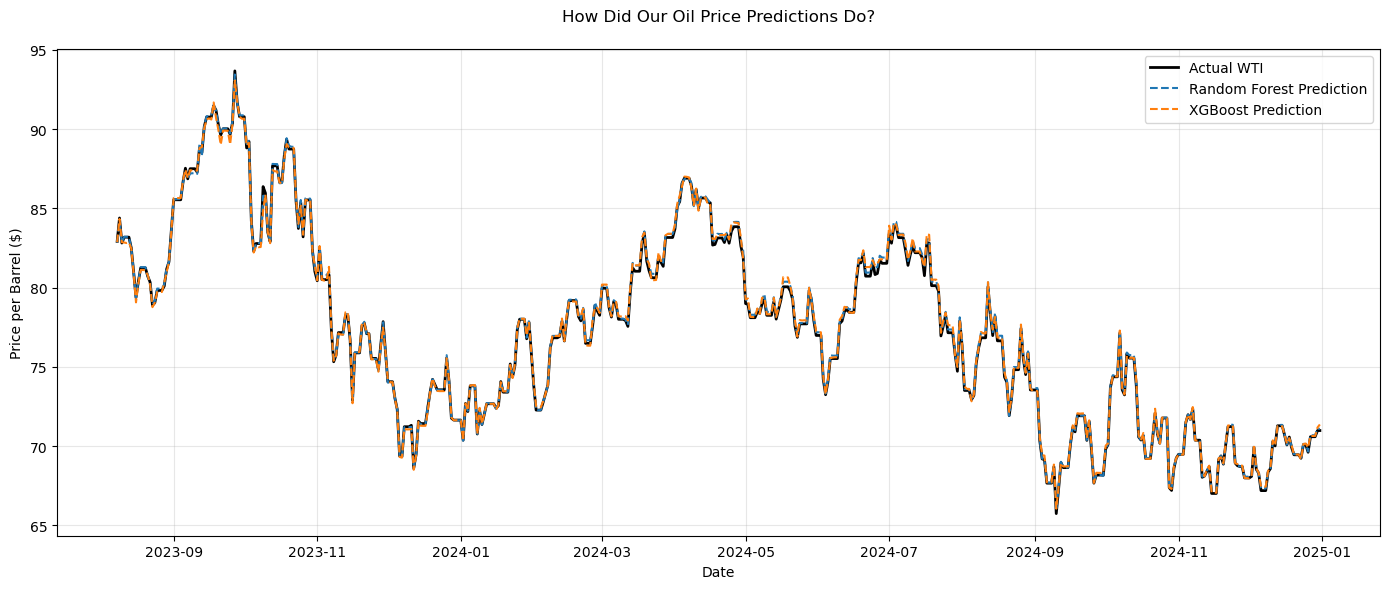

In [63]:
# Let's see how our models actually performed against real prices
import pandas as pd
import matplotlib.pyplot as plt

# Grab our predictions file - making sure dates are read properly
# (because time matters when we're looking at oil prices!)
df = pd.read_csv("xgb_rf_predictions_output.csv", parse_dates=["Date"])

# Setting up our plot - making it nice and wide so we can see the trends
plt.figure(figsize=(14, 6))  # 14 inches wide, 6 inches tall

# First, we will plot the actual prices 
plt.plot(df["Date"], df["Actual_WTI"], 
         label="Actual WTI", 
         color='black', 
         linewidth=2)

# Now add our Random Forest predictions as a dashed line
# The dashes help distinguish it from the actual prices
plt.plot(df["Date"], df["Predicted_WTI_RF"], 
         label="Random Forest Prediction", 
         linestyle='--')  # XGBoost will get a different color

# And our XGBoost predictions - matplotlib will automatically
# give this a different color from the RF predictions
plt.plot(df["Date"], df["Predicted_WTI_XGB"], 
         label="XGBoost Prediction", 
         linestyle='--')

plt.title("How Did Our Oil Price Predictions Do?", pad=20)  # pad adds some space
plt.xlabel("Date")
plt.ylabel("Price per Barrel ($)")
plt.legend()  # Show which line is which
plt.grid(True, alpha=0.3)  # Light grid lines for reference
plt.tight_layout()  # Prevents labels from getting cut off

#Final Graph
plt.show()


In [145]:
#error columns pre-processing
import pandas as pd
df = pd.read_csv("xgb_rf_predictions_output.csv", parse_dates = ["Date"])
df["RF_Error"] = (df["Actual_WTI"] - df["Predicted_WTI_RF"]).abs()
df["XGB_Error"] = (df["Actual_WTI"] - df["Predicted_WTI_XGB"]).abs()
df.to_csv("xgb_rf_predictions_with_errors.csv", index = False)
print("file updated with error columns for tableau")

file updated with error columns for tableau


In [147]:
# Step: Calculate confidence band using XGBoost error std deviation
import numpy as np

# We'll use signed errors for standard deviation
df["XGB_Residual"] = df["Actual_WTI"] - df["Predicted_WTI_XGB"]
xgb_std = df["XGB_Residual"].std()

# 95% confidence band = ±1.96 * std dev
df["Lower_Bound"] = df["Predicted_WTI_XGB"] - 1.96 * xgb_std
df["Upper_Bound"] = df["Predicted_WTI_XGB"] + 1.96 * xgb_std

# Optional: Export to CSV for Tableau
df[["Date", "Actual_WTI", "Predicted_WTI_XGB", "Lower_Bound", "Upper_Bound"]].to_csv("xgb_confidence_band.csv", index=False)
print("Confidence band added and file saved as 'xgb_confidence_band.csv'")


Confidence band added and file saved as 'xgb_confidence_band.csv'


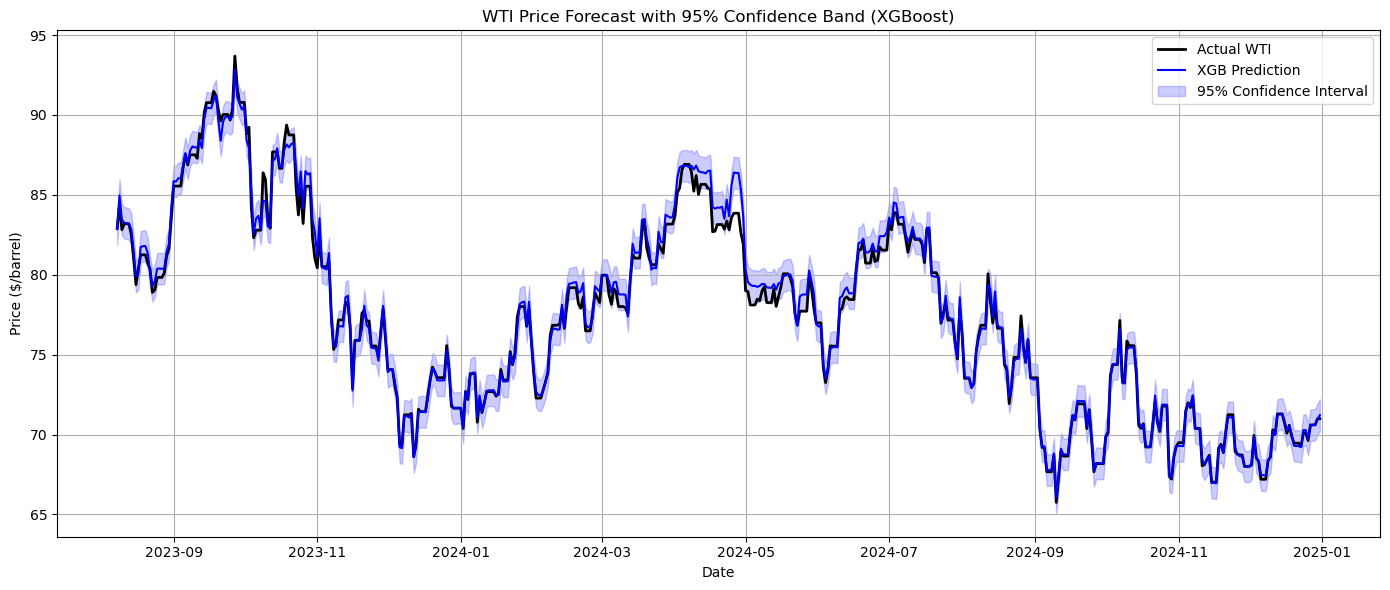

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Actual_WTI"], label="Actual WTI", color="black", linewidth=2)
plt.plot(df["Date"], df["Predicted_WTI_XGB"], label="XGB Prediction", color="blue")
plt.fill_between(df["Date"], df["Lower_Bound"], df["Upper_Bound"],
                 color="blue", alpha=0.2, label="95% Confidence Interval")

plt.title("WTI Price Forecast with 95% Confidence Band (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Price ($/barrel)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [68]:
import pandas as pd
# We will use X_train.columns to dynamically get the correct feature names
feature_names = X_train.columns

# Then, We will Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
})

# We will sort it out by descending importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Now, lets Display the feature importances
print(feature_importances)

# Finally, we will save to CSV
feature_importances.to_csv('feature_importances.csv', index=False)


                                 Feature    Importance
1                    wti_crude_eia_price  7.783529e-01
5                        opec_production  2.154771e-01
0                      brent_crude_price  1.186275e-03
26            wti_crude_price_rolling_7d  8.688809e-04
15         wti_crude_price_pct_change_3d  6.986356e-04
50                sentiment_adjusted_wti  6.717655e-04
34         wti_crude_price_volatility_7d  6.517432e-04
10                  wti_crude_price_lag1  6.007144e-04
51             oil_sentiment_interaction  3.796921e-04
14         wti_crude_price_pct_change_1d  3.748076e-04
28          brent_crude_price_rolling_7d  2.538939e-04
16         wti_crude_price_pct_change_7d  2.442536e-04
37      brent_crude_price_volatility_30d  4.902504e-05
35        wti_crude_price_volatility_30d  4.426149e-05
11                brent_crude_price_lag1  1.548347e-05
13                     us_dxy_index_lag1  9.700957e-06
31          Google_Sentiment_rolling_30d  9.684069e-06
39       G

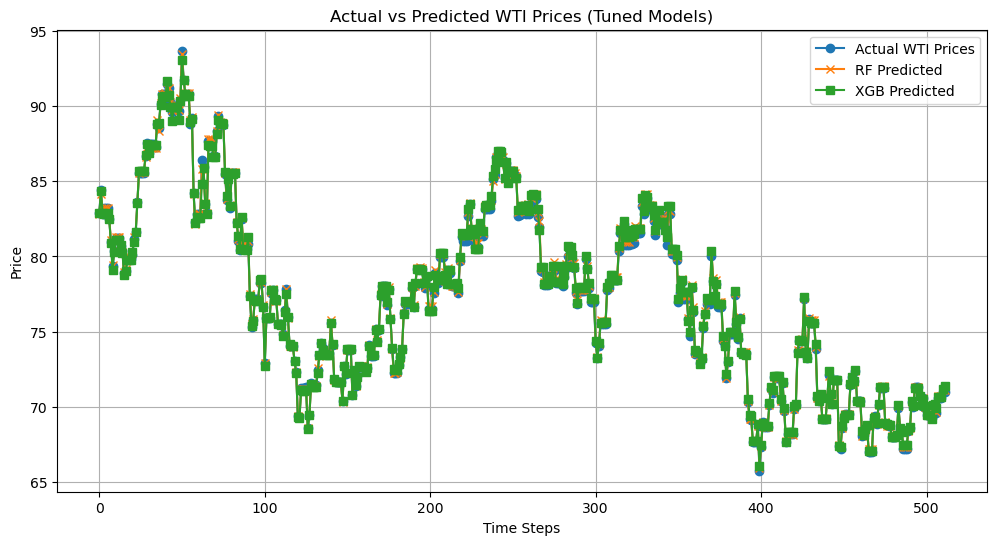

In [77]:
#Visual Representation to showcase the accuracy of the tuned models and the actual WTI prices
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual WTI Prices', marker='o')
plt.plot(rf_preds, label='RF Predicted', marker='x')
plt.plot(xgb_preds, label='XGB Predicted', marker='s')
plt.title('Actual vs Predicted WTI Prices (Tuned Models)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


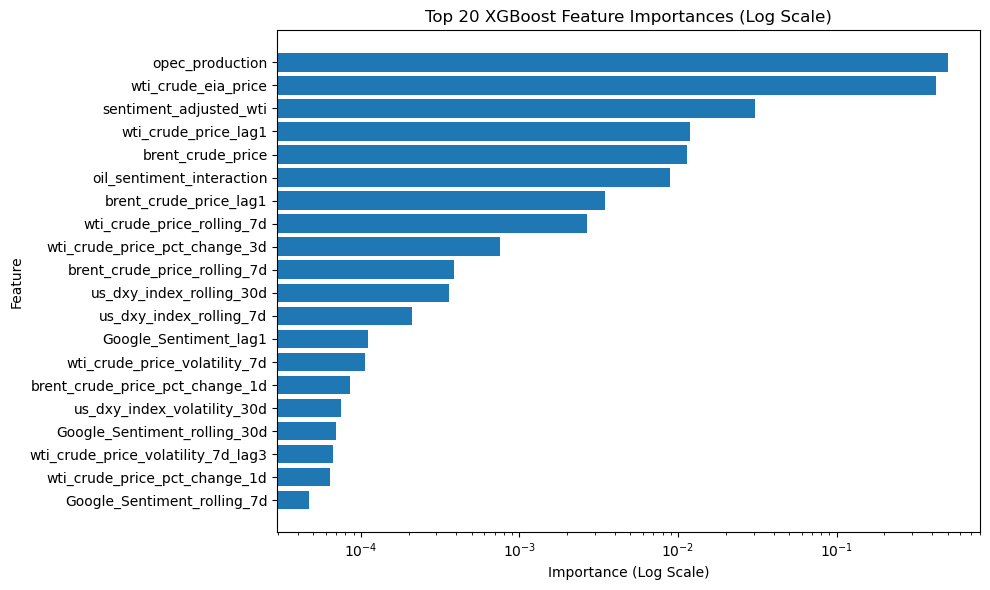

In [102]:
# XGBoost Feature Importance with Log Scale
xgb_importances = xgb_model.feature_importances_
xgb_features = X_train.columns
xgb_imp_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_importances})
xgb_imp_df = xgb_imp_df.sort_values('Importance', ascending=False)

# Plot
top_n = 20  # you can adjust this number
plt.figure(figsize=(10,6))
plt.barh(xgb_imp_df['Feature'].head(top_n)[::-1], xgb_imp_df['Importance'].head(top_n)[::-1])
plt.xscale('log')  # <<<<<< log scale
plt.title(f'Top {top_n} XGBoost Feature Importances (Log Scale)')
plt.xlabel('Importance (Log Scale)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


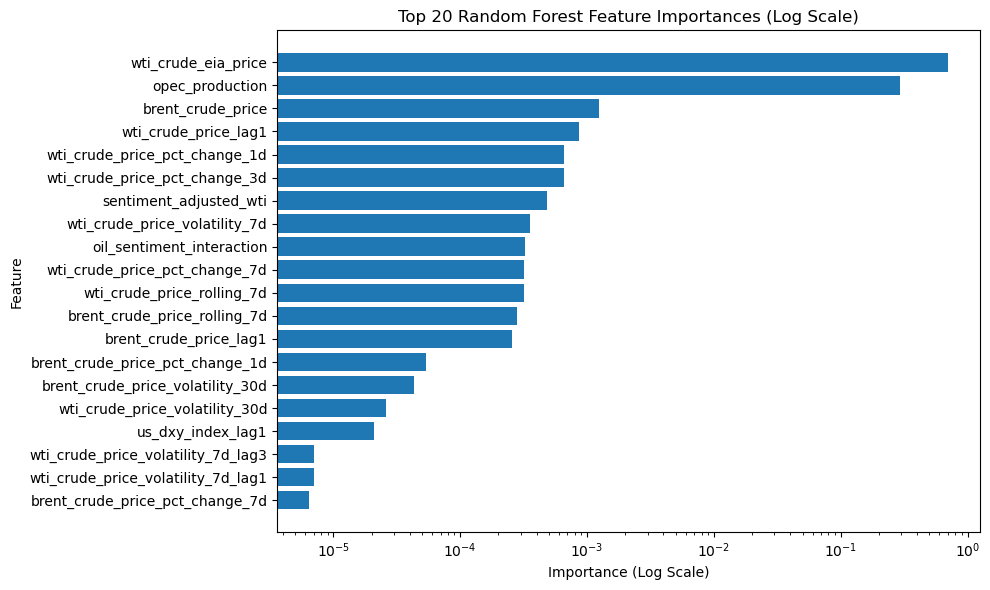

In [98]:
# Random Forest Feature Importance with Log Scale
top_n = 20  # show top 20
plt.figure(figsize=(10,6))
plt.barh(rf_imp_df['Feature'].head(top_n)[::-1], rf_imp_df['Importance'].head(top_n)[::-1])
plt.xscale('log')  # ADD LOG SCALE
plt.title(f'Top {top_n} Random Forest Feature Importances (Log Scale)')
plt.xlabel('Importance (Log Scale)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## 7. Conclusion

This project successfully builds a robust forecasting pipeline for WTI crude oil using machine learning. It ensures market-aligned outputs and prepares the data for business visualization. Future improvements may include integration of sentiment analysis or macroeconomic time-series inputs.
For more Visualisations, Please refer the tableau file or the attached screenshot of the dashboard.